In [0]:
# For Python 2 / 3 compatability
from __future__ import print_function

In [0]:
# Toy dataset.
# Format: each row is an example.
# The last column is the label.
# The first two columns are features.
# Feel free to play with it by adding more features & examples.
# Interesting note: I've written this so the 2nd and 5th examples
# have the same features, but different labels - so we can see how the
# tree handles this case.
training_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]

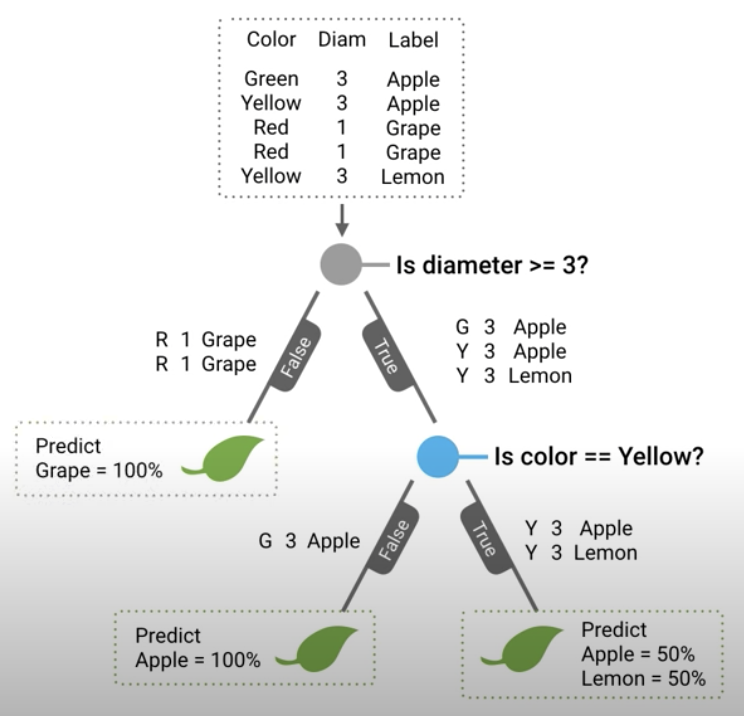

In [0]:
# Column labels.
# These are used only to print the tree.
header = ["color", "diameter", "label"]

In [0]:
def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])

In [0]:
#######
# Demo:
unique_vals(training_data, 0)
# unique_vals(training_data, 1)
#######

{'Green', 'Red', 'Yellow'}

In [0]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [0]:
#######
# Demo:
class_counts(training_data)
#######

{'Apple': 2, 'Grape': 2, 'Lemon': 1}

In [0]:
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

In [0]:
#######
# Demo:
# is_numeric(7)
is_numeric("Red")
#######

False

In [0]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Color) and a
    'column value' (e.g., Green). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))

In [0]:
#######
# Demo:
# Let's write a question for a numeric attribute
Question(1, 3)

Is diameter >= 3?

In [0]:
# How about one for a categorical attribute
q = Question(0, 'Green')
q

Is color == Green?

In [0]:
# Let's pick an example from the training set...
example = training_data[0]
# ... and see if it matches the question
q.match(example) # this will be true, since the first example is Green.
#######

True

In [0]:
def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [0]:
#######
# Demo:
# Let's partition the training data based on whether rows are Red.
true_rows, false_rows = partition(training_data, Question(0, 'Red'))
# This will contain all the 'Red' rows.
true_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

In [0]:
# This will contain everything else.
false_rows
#######

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [0]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows.

    There are a few different ways to do this, I thought this one was
    the most concise. See:
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

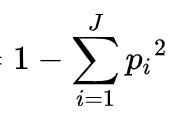

In [0]:
#######
# Demo:
# Let's look at some example to understand how Gini Impurity works.
#
# First, we'll look at a dataset with no mixing.
no_mixing = [['Apple'],
              ['Apple']]
# this will return 0
gini(no_mixing)

0.0

In [0]:
# Now, we'll look at dataset with a 50:50 apples:oranges ratio
some_mixing = [['Apple'],
               ['Orange']]
# this will return 0.5 - meaning, there's a 50% chance of misclassifying
# a random example we draw from the dataset.
gini(some_mixing)

0.5

In [0]:
1-0.36

0.64

In [0]:
# Now, we'll look at a dataset with many different labels
lots_of_mixing = [['Apple'],
                  ['Apple'],
                  ['Grape'],
                  ['Grape'],
                  ['Blueberry']]
# This will return 0.8
gini(lots_of_mixing)
#######

0.6399999999999999

In [0]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [0]:
#######
# Demo:
# Calculate the uncertainy of our training data.
current_uncertainty = gini(training_data)
current_uncertainty

0.6399999999999999

In [0]:
# How much information do we gain by partioning on 'Green'?
true_rows, false_rows = partition(training_data, Question(0, 'Green'))
info_gain(true_rows, false_rows, current_uncertainty)

0.1399999999999999

In [0]:
# What about if we partioned on 'Red' instead?
true_rows, false_rows = partition(training_data, Question(0,'Red'))
info_gain(true_rows, false_rows, current_uncertainty)

0.37333333333333324

In [0]:
# It looks like we learned more using 'Red' (0.37), than 'Green' (0.14).
# Why? Look at the different splits that result, and see which one
# looks more 'unmixed' to you.
true_rows, false_rows = partition(training_data, Question(0,'Red'))

# Here, the true_rows contain only 'Grapes'.
true_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

In [0]:
# And the false rows contain two types of fruit. Not too bad.
false_rows

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [0]:
# On the other hand, partitioning by Green doesn't help so much.
true_rows, false_rows = partition(training_data, Question(0,'Green'))

# We've isolated one apple in the true rows.
true_rows

[['Green', 3, 'Apple']]

In [0]:
# But, the false-rows are badly mixed up.
false_rows
#######

[['Yellow', 3, 'Apple'],
 ['Red', 1, 'Grape'],
 ['Red', 1, 'Grape'],
 ['Yellow', 3, 'Lemon']]

In [0]:
def find_best_split(rows):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value
            
            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)
            print(val, gain)
            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset.
            if gain > best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [0]:
#######
# Demo:
# Find the best question to ask first for our toy dataset.
best_gain, best_question = find_best_split(training_data)
best_question
# FYI: is color == Red is just as good. See the note in the code above
# where I used '>='.
#######

Green 0.14
Red 0.373333333333
Yellow 0.173333333333
3 0.373333333333


Is color == Red?

In [0]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [0]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [0]:
def build_tree(rows):
    """Builds the tree.

    Rules of recursion: 1) Believe that it works. 2) Start by checking
    for the base case (no further information gain). 3) Prepare for
    giant stack traces.
    """

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # dependingo on the answer.
    return Decision_Node(question, true_branch, false_branch)

In [0]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [0]:
my_tree = build_tree(training_data)

Green 0.14
Red 0.373333333333
Yellow 0.173333333333
3 0.373333333333
Green 0.111111111111
Yellow 0.111111111111


In [0]:
print_tree(my_tree)

Is color == Red?
--> True:
  Predict {'Grape': 2}
--> False:
  Is color == Yellow?
  --> True:
    Predict {'Lemon': 1, 'Apple': 1}
  --> False:
    Predict {'Apple': 1}


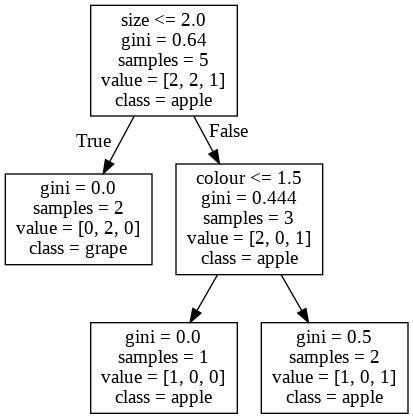

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus

# green-1, yellow-2, red-3
X = [
    [1, 3],
    [2, 3],
    [3, 1],
    [3, 1],
    [2, 3],
]

y = [
    ['Apple'],
    ['Apple'],
    ['Grape'],
    ['Grape'],
    ['Lemon'],
]

# Create decision tree classifer object
clf = DecisionTreeClassifier(random_state=0)

# Train model
model = clf.fit(X, y)

# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=["colour","size"],  
                                class_names=["apple","grape","lemon"])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["apple", "grape", "orange"])
le.transform(["apple", "grape", "orange"]) 

array([0, 1, 2])

In [0]:
list(le.inverse_transform([0,1,2]))

['apple', 'grape', 'orange']

In [0]:
def classify(row, node):
    """See the 'rules of recursion' above."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [0]:
#######
# Demo:
# The tree predicts the 1st row of our
# training data is an apple with confidence 1.
classify(training_data[0], my_tree)
#######

{'Apple': 1}

In [0]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [0]:
#######
# Demo:
# Printing that a bit nicer
print_leaf(classify(training_data[0], my_tree))
#######

{'Apple': '100%'}

In [0]:
#######
# Demo:
# On the second example, the confidence is lower
print_leaf(classify(training_data[1], my_tree))
#######

{'Apple': '50%', 'Lemon': '50%'}

In [0]:
# Evaluate
testing_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 4, 'Apple'],
    ['Red', 2, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]

In [0]:
for row in testing_data:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_tree))))

Actual: Apple. Predicted: {'Apple': '100%'}
Actual: Apple. Predicted: {'Lemon': '50%', 'Apple': '50%'}
Actual: Grape. Predicted: {'Grape': '100%'}
Actual: Grape. Predicted: {'Grape': '100%'}
Actual: Lemon. Predicted: {'Lemon': '50%', 'Apple': '50%'}


In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

In [0]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   31G   72G  31% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.9G  4.0K  5.9G   1% /dev/shm
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1       114G   33G   82G  29% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [0]:
!cat /proc/meminfo 

MemTotal:       13333540 kB
MemFree:        10695252 kB
MemAvailable:   12478444 kB
Buffers:           72408 kB
Cached:          1870312 kB
SwapCached:            0 kB
Active:           720604 kB
Inactive:        1663188 kB
Active(anon):     421648 kB
Inactive(anon):      320 kB
Active(file):     298956 kB
Inactive(file):  1662868 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               276 kB
Writeback:             0 kB
AnonPages:        441184 kB
Mapped:           184148 kB
Shmem:               904 kB
Slab:             161248 kB
SReclaimable:     124692 kB
SUnreclaim:        36556 kB
KernelStack:        3520 kB
PageTables:         5100 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666768 kB
Committed_AS:    2528500 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              904 kB
AnonHugePages:   

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5347455817577296247, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5061909877328622325
 physical_device_desc: "device: XLA_CPU device"]